In this demo, we will experiment with different sets of parameters, and how this affects the number of slots available for SIMD operations, and the serialized size of encrypted inputs.

In [1]:
import os
if "SHEEP_HOME" in os.environ.keys():
  SHEEP_HOME = os.environ["SHEEP_HOME"]
else:
  print("Please set environment variable SHEEP_HOME to point to the location of SHEEP/frontend")
import sys
sys.path.append(SHEEP_HOME)

In [2]:
from pysheep import sheep_client
from pysheep.database import upload_ciphertext_result

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
sheep_client.new_job()

{'content': '', 'status_code': 200}

Lets use HElib_F2 and vary the BaseParamSet parameter (which in turn chooses pre-set values for other parameters):

In [5]:
sheep_client.set_context("HElib_F2")
sheep_client.set_input_type("int8_t")
sheep_client.get_parameters()

{'content': {'BaseParamSet': 0,
  'BitsPerLevel': 25,
  'Bootstrap': 1,
  'HammingWeight': 128,
  'Levels': 30,
  'c': 2,
  'd': 12,
  'g1': 71,
  'g2': 76,
  'g3': 0,
  'm': 105,
  'm1': 3,
  'm2': 35,
  'm3': 0,
  'ord1': 2,
  'ord2': 2,
  'ord3': 0,
  'phim': 48},
 'status_code': 200}

With BaseParamSet=0, how many slots for SIMD operations do we get?

In [6]:
num_slots = sheep_client.get_nslots()['content']['nslots']
num_slots

4

And how big is the ciphertext if we encrypt one input (which is a vector of 4 values since we have 4 slots)?

In [7]:
size=sheep_client.encrypt_and_serialize([1,2,3,4])["content"]["size"]
size

179177

We can do a scan for HElib, seeing how things vary with the "BaseParamSet" parameter, which in turn chooses a set of preconfigured values for the other parameters.

In [8]:
for i in range(5):
    try:
        sheep_client.set_parameters({"BaseParamSet": i})
        param_dict = sheep_client.get_parameters()["content"]
        num_slots = sheep_client.get_nslots()['content']['nslots']
        ciphertext_size = sheep_client.encrypt_and_serialize([1,2,3,4])['content']['size']
        upload_ciphertext_result("HElib_F2","int8_t",num_slots, ciphertext_size, param_dict)
    except:
        print("Problem setting BaseParamSet to {}".format(i))
        pass

## Querying the database and plotting results

The previous cell should have uploaded some results to the "ciphertext" table in our SQLite database.  We can query this using some SQLAlchemy shortcuts, and put the results into a dataframe

In [9]:
from pysheep.database import session, CiphertextMeasurement
rows = session.query(CiphertextMeasurement).all()

In [10]:
df_dict = {"context": [], "input_bitwidth": [], "BaseParamSet": [], "nslots": [], "ctsize": []}
for row in rows:
    for param in row.parameters:
        if param.param_name == "BaseParamSet" and param.param_value not in df_dict["BaseParamSet"]:
            df_dict["context"].append(row.context)
            df_dict["input_bitwidth"].append(row.input_bitwidth)
            df_dict["nslots"].append(row.num_slots)
            df_dict["ctsize"].append(row.ciphertext_size)
            df_dict["BaseParamSet"].append(param.param_value)
df = pd.DataFrame(df_dict)
df

,BaseParamSet,context,ctsize,input_bitwidth,nslots
0,0,HElib_F2,179111,8,4
1,1,HElib_F2,2210406,8,60
2,2,HElib_F2,8389112,8,96
3,3,HElib_F2,54561692,8,682


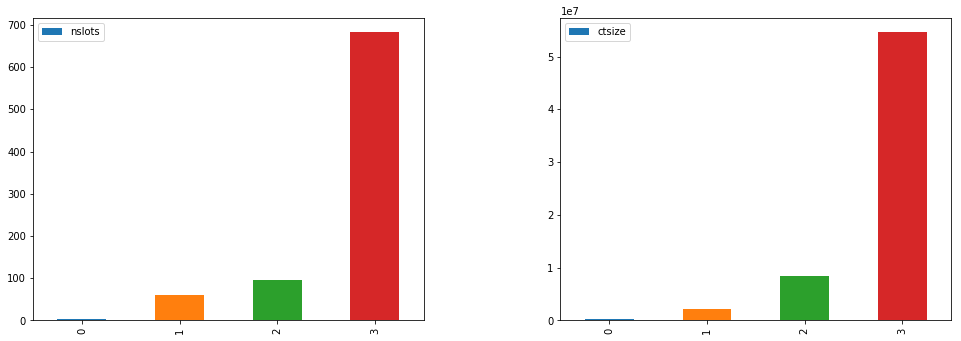

In [11]:
axis = plt.subplot(121)
df.plot(ax=axis, use_index=False,x='BaseParamSet', y='nslots',kind='bar',figsize=(15, 5))
axis = plt.subplot(122)
df.plot(ax=axis, use_index=False,x='BaseParamSet', y='ctsize',kind='bar',figsize=(15, 5))
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

## Other contexts

TFHE and libpaillier by default only offer one slot.   Lets compare their serialized ciphertext sizes:

In [12]:
for context in ["TFHE","LP"]:
    for input_type in ["bool","int8_t","int16_t","int32_t"]:
        sheep_client.set_context(context)
        sheep_client.set_input_type(input_type)
        param_dict = sheep_client.get_parameters()["content"]
        num_slots = sheep_client.get_nslots()["content"]["nslots"]
        ciphertext_size = sheep_client.encrypt_and_serialize([1])['content']['size']
        upload_ciphertext_result(context,input_type,num_slots, ciphertext_size, param_dict)
    

In [13]:
from sqlalchemy import or_
rows = session.query(CiphertextMeasurement).filter(or_(CiphertextMeasurement.context == 'TFHE', 
                                                       CiphertextMeasurement.context == 'LP')).all()
df_dict = {"context": [], "input_bitwidth": [], "ctsize": []}
for row in rows:
        df_dict["context"].append(row.context)
        df_dict["input_bitwidth"].append(row.input_bitwidth)
        df_dict["ctsize"].append(row.ciphertext_size)
df = pd.DataFrame(df_dict)
df

,context,ctsize,input_bitwidth
0,TFHE,2016,1
1,TFHE,16128,8
2,TFHE,32256,16
3,TFHE,64512,32
4,LP,64,1
5,LP,64,8
6,LP,64,16
7,LP,64,32


We can see that libpaillier has a very small ciphertext size, which is expected as Paillier is quite a simple encryption scheme.  Also, for libpaillier, the size is always the same, while for TFHE it grows linearly with bitwidth.  This is also expected as TFHE operates on the binary plaintext domain, and treats an integer as an array of bits.